##Notebook 03 — Liquidation Engine & Bad Debt Formation (One-Step Waterfall)

This notebook extends the trigger-only analysis from Notebook 02 by simulating what actually happens after liquidation is triggered: how much debt can be repaid, how much collateral is seized, and how much residual bad debt remains when collateral liquidation is imperfect.

While Health Factor (HF) tells us whether a position is liquidatable (HF < 1), it does not tell us whether liquidation is successful in fully covering the debt. In real lending protocols, outcomes depend on liquidation mechanics and market frictions: close factor limits how much debt can be repaid per event, liquidation bonus changes how much collateral must be given to liquidators, and slippage reduces effective sale proceeds. These mechanics create the gap between “liquidatable” and “bad debt.”

The workflow consists of:

	1.	Loading the synthetic position book (from the same generation assumptions in Notebook 01) and setting baseline protocol parameters
	2.	Defining a one-step liquidation model with:
	•	trigger rule (HF < 1)
	•	close factor (max repay fraction)
	•	liquidation bonus (liquidator incentive)
	•	slippage (execution friction / haircut)
	3.	Running a stress grid across (price shock × delay proxy), reusing the same shock grid structure as Notebook 02 for consistency
	4.	Computing liquidation outcomes per scenario, including:
	•	liquidatable rate
	•	total bad debt (USD)
	•	bad debt rate (bad debt / initial total debt)
	5.	Visualizing stress surfaces:
	•	bad debt rate vs. price shock (baseline delay = 0)
	•	bad debt rate heatmap across (shock × delay) to show how delay amplifies loss formation

The resulting bad-debt surfaces quantify how liquidation mechanics translate market shocks into protocol solvency losses, and they provide the core loss engine inputs for later notebooks that perform parameter sweeps (LT, close factor, bonus, slippage) and policy optimization under multi-scenario risk constraints.

In [ ]:
#1. Imports

!rm -rf b1-defi-risk
!git clone https://github.com/lydialydia-lydia/b1-defi-risk.git
%cd b1-defi-risk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.sim_data import generate_synthetic_positions
from src.liquidation import simulate_one_step_liquidation

Cloning into 'b1-defi-risk'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 53 (delta 19), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 138.93 KiB | 3.75 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/b1-defi-risk


In [ ]:
#2. Generate positions (reproducible)
SEED = 42
positions = generate_synthetic_positions(seed=SEED)

# Convenience scalars used throughout stress tests
price_init = float(positions["collateral_price_init"].iloc[0])
total_debt = float(positions["debt_amount"].sum())

print("positions:", positions.shape, "| price_init:", price_init, "| total_debt:", total_debt)
positions.head()

positions: (10000, 8) | price_init: 2500.0 | total_debt: 25542712.62433892


,position_id,collateral_asset,debt_asset,collateral_amount,debt_amount,collateral_price_init,collateral_value_init,target_ltv
0,1,ETH,USD,1.356241,2149.988760,2500.0,3390.603102,0.634102
1,2,ETH,USD,0.353460,611.424356,2500.0,883.650749,0.691930
2,3,ETH,USD,2.117955,2659.190187,2500.0,5294.888534,0.502218
3,4,ETH,USD,2.561427,3824.058498,2500.0,6403.568725,0.597176
4,5,ETH,USD,0.142127,243.865636,2500.0,355.317168,0.686332


In [ ]:
#3. Parameters + stress grid
# Protocol parameters (simplified)
LIQUIDATION_THRESHOLD = 0.80   # LT
CLOSE_FACTOR = 0.50            # max fraction of debt repaid in one event
LIQUIDATION_BONUS = 0.08       # liquidation incentive
SLIPPAGE = 0.02                # execution friction haircut


'''
LT=0.8 is a common ballpark: gives a buffer vs price moves while still allowing leverage.
Close factor limits per-event liquidation size (avoid full wipe instantly; more realistic "partial" liquidation).
Liquidation bonus incentivizes liquidators/keepers to execute quickly; 5–10% is a typical range.
Slippage models execution friction (MEV / thin liquidity / market impact). 2% is a mild-but-nonzero baseline.
'''


# Stress grid
price_shocks = np.arange(0.0, -0.81, -0.05) # Collateral price shock from 0% down to -80% (covers normal drawdowns to crisis scenarios).

delay_levels = [0, 1, 2, 3]
delay_to_extra_drop = {0: 0.00, # no delay
                       1: -0.02, # small lag
                       2: -0.05, # medium lag
                       3: -0.10 # severe lag (fast crash where protocol reacts late)
                       }


In [ ]:
#4. Run stress grid and compute bad debt
# For each (shock, delay) scenario, estimate:
#   - how much of the book becomes liquidatable (HF < 1)
#   - how much bad debt remains after a one-step liquidation attempt

rows = []
for shock in price_shocks:
    for delay in delay_levels:
      # Effective shock combines market drop + delay penalty (stale oracle / late execution proxy)
      total_shock = shock + delay_to_extra_drop[delay]
      stressed_price = price_init * (1.0 + total_shock)

      sim = simulate_one_step_liquidation(
          collateral_amount=positions["collateral_amount"],
          debt_amount=positions["debt_amount"],
          price=stressed_price,
          liquidation_threshold=LIQUIDATION_THRESHOLD,
          close_factor=CLOSE_FACTOR,
          liquidation_bonus=LIQUIDATION_BONUS,
          slippage=SLIPPAGE
      )

      liquidatable_rate = sim["is_liquidatable"].mean()
      bad_debt_total = float(sim["bad_debt"].sum())
      bad_debt_rate = bad_debt_total / total_debt

      rows.append({
          "price_shock": shock,
          "delay_level": delay,
          "total_shock": total_shock,
          "stressed_price": stressed_price,
          "liquidatable_rate": liquidatable_rate,
          "bad_debt_total": bad_debt_total,
          "bad_debt_rate": bad_debt_rate,
          "LT": LIQUIDATION_THRESHOLD,
          "close_factor": CLOSE_FACTOR,
          "liq_bonus": LIQUIDATION_BONUS,
          "slippage": SLIPPAGE
        })

stress_results = pd.DataFrame(rows)
stress_results.head()

,price_shock,delay_level,total_shock,stressed_price,liquidatable_rate,bad_debt_total,bad_debt_rate,LT,close_factor,liq_bonus,slippage
0,0.00,0,0.00,2500.0,0.0123,2.169120e+05,0.008492,0.8,0.5,0.08,0.02
1,0.00,1,-0.02,2450.0,0.0215,3.925011e+05,0.015366,0.8,0.5,0.08,0.02
2,0.00,2,-0.05,2375.0,0.0451,7.806575e+05,0.030563,0.8,0.5,0.08,0.02
3,0.00,3,-0.10,2250.0,0.1141,1.792510e+06,0.070177,0.8,0.5,0.08,0.02
4,-0.05,0,-0.05,2375.0,0.0451,7.806575e+05,0.030563,0.8,0.5,0.08,0.02


In [ ]:
from pathlib import Path

# Save figures
FIG_DIR = Path("/content/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

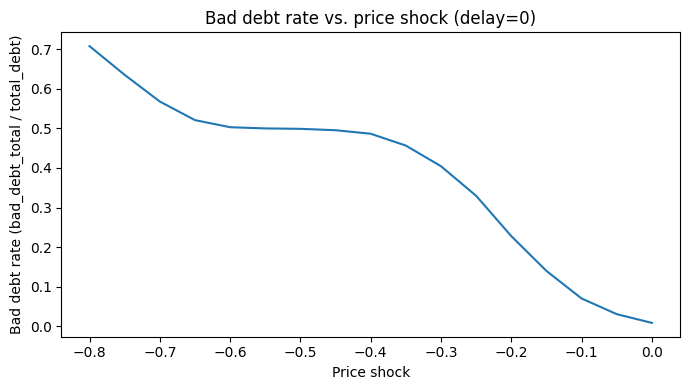

In [ ]:
#5. Curve: bad debt vs price shock (holding delay fixed at 0)
# Intuition: more negative shock => less collateral value => more residual (uncovered) debt => higher bad debt rate

curve0 = stress_results[stress_results["delay_level"] == 0].sort_values("price_shock")  ## left = worst (-80%), right = normal (0%)

plt.figure(figsize=(7, 4))
plt.plot(curve0["price_shock"], curve0["bad_debt_rate"])
plt.title("Bad debt rate vs. price shock (delay=0)")
plt.xlabel("Price shock")
plt.ylabel("Bad debt rate (bad_debt_total / total_debt)")
plt.tight_layout()

#save figure
curve_path = FIG_DIR / "03_bad_debt_rate_vs_price_shock_delay0.png"
plt.savefig(curve_path, dpi=200, bbox_inches="tight")
plt.show()

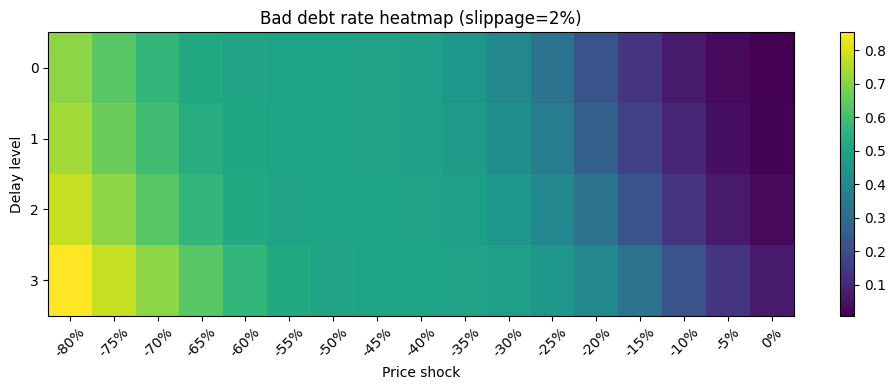

In [ ]:
#6. Heatmap: bad debt rate (shock × delay)
pivot_bad = stress_results.pivot(index="delay_level", columns="price_shock", values="bad_debt_rate")

plt.figure(figsize=(10, 4))
plt.imshow(pivot_bad.values, aspect="auto")
plt.title(f"Bad debt rate heatmap (slippage={SLIPPAGE:.0%})")
plt.xlabel("Price shock")
plt.ylabel("Delay level")

x_labels = [f"{c:.0%}" for c in pivot_bad.columns]
plt.xticks(range(len(pivot_bad.columns)), x_labels, rotation=45)
plt.yticks(range(len(pivot_bad.index)), [str(i) for i in pivot_bad.index])

plt.colorbar()
plt.tight_layout()

#save figure
heatmap_path = FIG_DIR / "03_bad_debt_rate_heatmap.png"
plt.savefig(heatmap_path, dpi=200, bbox_inches="tight")
plt.show()